In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
folder = './Data/img_data'
image_size = (224, 224)
batch_size = 32

In [3]:
from keras.preprocessing.image import ImageDataGenerator
classes = ['empty', 'antonym']
datagen = ImageDataGenerator(
        rotation_range=5,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = datagen.flow_from_directory(
    folder + '/train/',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    classes=classes,
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(
    folder + '/test/',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    classes=classes,
    shuffle=False 
)

Found 2427 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.


In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

model = VGG16(weights='imagenet')
model.summary()

2022-03-01 11:04:04.627575: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [9]:
epochs = 10

history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
# model.save_weights('model_VGG16.h5') 
model.save('model_VGG16_weight_empty.h5') 

Epoch 1/10
76/76 [==============================] - 363s 5s/step - loss: 0.3425 - categorical_accuracy: 0.9514 - val_loss: 0.0104 - val_categorical_accuracy: 0.9984
Epoch 2/10
76/76 [==============================] - 354s 5s/step - loss: 0.0142 - categorical_accuracy: 0.9963 - val_loss: 0.0085 - val_categorical_accuracy: 0.9971
Epoch 3/10
76/76 [==============================] - 352s 5s/step - loss: 0.0166 - categorical_accuracy: 0.9955 - val_loss: 0.0057 - val_categorical_accuracy: 0.9975
Epoch 4/10
76/76 [==============================] - 375s 5s/step - loss: 0.0120 - categorical_accuracy: 0.9975 - val_loss: 0.0028 - val_categorical_accuracy: 0.9992
Epoch 5/10
76/76 [==============================] - 363s 5s/step - loss: 0.0105 - categorical_accuracy: 0.9963 - val_loss: 0.0018 - val_categorical_accuracy: 0.9992
Epoch 6/10
76/76 [==============================] - 360s 5s/step - loss: 0.0101 - categorical_accuracy: 0.9967 - val_loss: 0.0020 - val_categorical_accuracy: 0.9996
Epoch 7/10

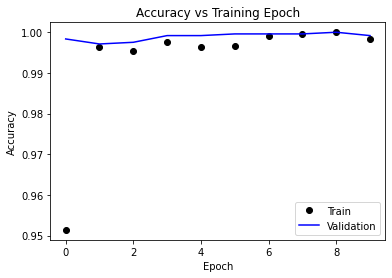

In [10]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

/var/folders/9_/zlm44mjd71z0x26t7h6894980000gn/T/ipykernel_19608/284986293.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen)


3.03125


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

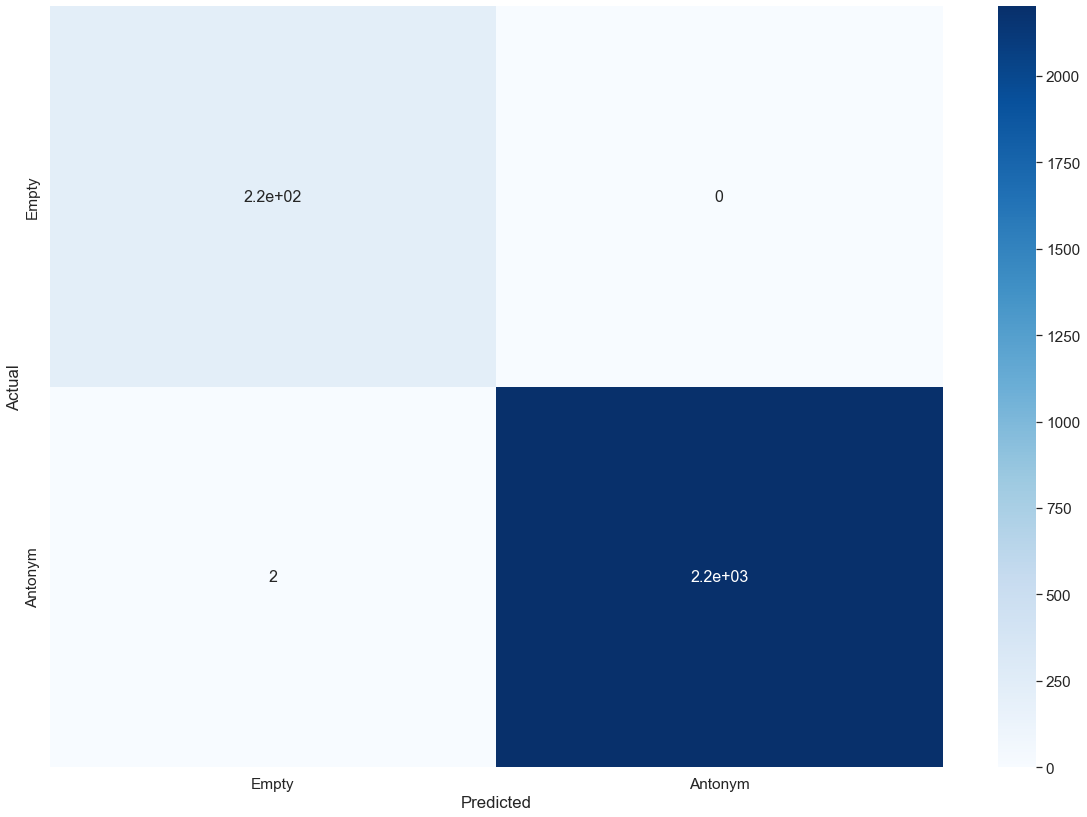

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['Empty', 'Antonym']

test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import decode_predictions

model_two = VGG19(weights='imagenet')
model_two.summary()

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model_two = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model_two.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model_two.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model_two = Model(inputs=base_model_two.input, outputs=predictions)
model_two.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'VGG19' is not defined

In [ ]:
epochs = 10

history = model_two.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG19_empty.h5') 

In [ ]:
test_gen.reset()
Y_pred = model_two.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


print('Confusion Matrix')
print(confusion_matrix(classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

In [ ]:
import math
import cv2
import numpy as np
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict
from statistics import mean
import chess
import chess.svg
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import re
import glob
import PIL

In [ ]:

from cv_chess_functions import prepare_image
from keras.models import load_model
img = prepare_image('./test.jpeg')

In [ ]:
model = load_model('model_VGG16_weight_empty.h5')

In [ ]:


out = model.predict(img)

print(out)

In [ ]:
category_reference = {0: 'b', 1: 'k', 2: 'n', 3: 'p', 4: 'q', 5: 'r', 6: '1', 7: 'B', 8: 'K', 9: 'N', 10: 'P',
11: 'Q', 12: 'R'}
top_pred = np.argmax(out)
pred = category_reference[top_pred]
print(pred)

In [ ]:
import sys
print(sys.version)
print(sys.path)